# $\color{Blue}{\text{Universality of homoscedastic mixtures - Random teacher regression}}$

## Data preprocessing 

In this notebook we reproduce the plots in Figure 1: Random teacher regression on pre-processed real datasets with Random Features. 


First we import different scientific computing Python packages, moreover we exploit functions built in the script *preprocess.py*. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from pathlib import Path
from preprocess import *
from learning_curve_utils import *

The first step is to import the data and preprocess them. We consider in the following Fashion-MNIST with random features processing with a *erf()* non-linearity using the function *get_real_data*. 

The user may change the data under analysis by changing the three numbers appearing in the variable *triplet*:

* $\color{purple}{\text{a = triplet[0] selects the data:}}$ 
  - a = 0 -> MNIST 
  - a = 1 -> Fashion-MNIST 
  - a = 2 -> CIFAR10 - grayscale 
  
* $\color{purple}{\text{b = triplet[1] selects the preprocessing step:}}$ 
  - b = 0 -> No transorm 
  - b = 1: 
    - a = 0 -> Hadamard transform 
    - a = 1 -> Discrete cosine transform 
    - a = 2 -> Orthogonal projection 
  - b = 2 -> Random Gaussian featues

* $\color{purple}{\text{c = triplet[2] selects the non-linearity:}}$
  - c = 0 -> No non-linearity
  - c = 1 -> *relu()*
  - c = 2 -> *erf()*
  - c = 3 -> *tanh()*
  - c = 4 -> *sign()*

In [2]:
triplet = (2,2,2)
a,b,c = triplet 
which_real_dataset = "MNIST" if a==0 else "fashion-MNIST" if a==1 else "CIFAR10"
which_transform = 'no_transform' if b == 0 else "other" if b==1 else 'random_gaussian_features' 
which_non_lin = 'no_transform' if c ==0 else 'relu' if c==1  else 'erf' if c==2 else 'tanh' if c==3 else 'sign'

Choose the path where storing the data and the results and load the preprocessed real dataset with the function *get_real_data*.

In [3]:
path_to_data_folder = "./data"
loss = "square_loss"
path_to_res_folder = f"./results_regression/dataset_{a}_transform_{b}_nonlin_{c}"
resfile = "res_%s_real.csv"%(loss)
p = 2000
get_real_data(p, which_real_dataset = which_real_dataset, which_transform = which_transform, 
                    which_non_lin = which_non_lin, path_to_data_folder = path_to_data_folder)    

## Learning curve

Choose the value of the regularization for the ERM and the noise level in the teacher function: $\lambda , \Delta$:

In [4]:
λ = 1e-15
noise = 0.3

Now we are in the position to compute the learning curve, i.e. runnning for different $\alpha = \frac nd$ the ERM fit with the function *get_learning_curve_real*. 

In [5]:
my_file = Path(f'{path_to_res_folder}/sim_square_loss_real.csv')
if my_file.is_file():
    print(f'already computed - ridge simulation with lamb = {λ} and triplet = {triplet} and noise = {noise}')
else: 
    # Import the empirical covariance matrix in order to compute the estimation for the overlaps appearing in the replica equations #
    μ_real, Σ_real = build_covariances_real(p = p, which_real_dataset = which_real_dataset, 
                        which_transform = which_transform, which_non_lin = which_non_lin, 
                        path_to_data_folder = path_to_data_folder) 
    print(f'START ridge simulation with lamb = {λ} and triplet = {triplet} and noise = {noise}')
    p , p = Σ_real.shape
    # Average over 25 different runs #
    n_seeds = 10
    solver = 'sk'
    # Choose the vector of sample complexity #
    αs = np.linspace(0.3,4,20)
    for seed in range(n_seeds):
        print("Run # ", seed)
        # Compute the learning curve for the given seed # 
        get_learning_curve_real(Cov = Σ_real, noise = noise ,αs = αs, λ = λ, task = 'regression', loss = loss, which_real_dataset = which_real_dataset, 
                        which_transform = which_transform, which_non_lin = which_non_lin,
                        path_to_data_folder = path_to_data_folder, path_to_res_folder = path_to_res_folder, 
                        solver = solver, seed = seed)
    statistics_learning_curve_real(n_seeds = n_seeds, loss = loss, path_to_res_folder = path_to_res_folder)
    print(f'FINISH ridge simulation with lamb = {λ} and triplet = {triplet} and noise = {noise}')

Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
START ridge simulation with lamb = 1e-15 and triplet = (2, 2, 2) and noise = 0.3
Run #  0
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  1
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  2
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  3
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  4
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  5
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  6
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  7
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  8
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
Run #  9
Keys: <KeysViewHDF5 ['X_CIFAR10_random_gaussian_features_erf']>
FINISH ridge simulation with lamb = 1e-15 and triplet = (2, 2, 2) and noise = 0.3


In [17]:
sim = pd.read_csv(my_file)
sim['mean_train_loss'] *= 2/noise ; sim['mean_test_error'] /= noise

In [18]:
xs1 = np.linspace(0.3,0.999,300) ; xs2 = np.linspace(1.0001,4,300)
xs = np.union1d(xs1,xs2)
eg_closed1 , et_closed1, eg_closed2 , et_closed2 = [] , [] , [], []
for x in xs1: 
    auxt = 0
    auxg = ((x-1)**2 + 1)/(1-x) 
    eg_closed1.append(auxg) ; et_closed1.append(auxt)
for x in xs2:
    auxt = (x-1)/x
    auxg = x/(x-1)
    eg_closed2.append(auxg) ; et_closed2.append(auxt)

Text(0, 0.5, ' $\\varepsilon_{tr} \\, / \\, \\Delta$ - Square loss')

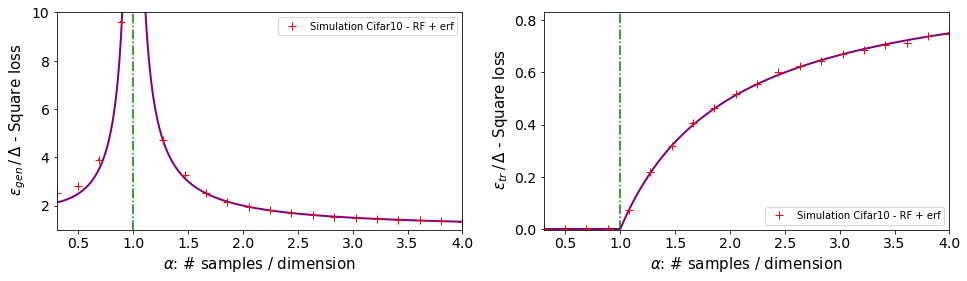

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
# plt.suptitle(fr"Learning curves: Random teacher - {task} -  $\lambda$ = {λ} - noise variance = {noise}")
leg_code = 'Cifar10 - RF + erf'
sim.plot(x='alpha',
        y='mean_train_loss',
        yerr = 'std_train_loss',        
        color = 'r',
        marker = '+',
        markersize = 8,                                                                         
        lw = 2,
        linestyle='None',
        ax=ax[1],
        label=f'Simulation {leg_code}')

sim.plot(x='alpha',
        y='mean_test_error',
        yerr = 'std_test_error',        
        color ='r',
        marker = '+',
        markersize = 8,                                                                         
        lw = 2,
        linestyle='None',
        ax=ax[0],
        label=f'Simulation {leg_code}')
        
### Identity  ###      
ax[0].plot(xs1,eg_closed1, label = r'GCM - $\Sigma = Id$ - $\lambda = 0$',linewidth=2,c='purple')
ax[1].plot(xs1,et_closed1, label = r'GCM - $\Sigma = Id $ - $\lambda = 0$',linewidth=2,c='purple') 
ax[0].plot(xs2,eg_closed2, label = r'GCM - $\Sigma = Id$ - $\lambda = 0$',linewidth=2,c='purple')
ax[1].plot(xs2,et_closed2, label = r'GCM - $\Sigma = Id $ - $\lambda = 0$',linewidth=2,c='purple') 
ax[0].axvline(1,linestyle = '-.', c= 'green') ; ax[1].axvline(1,linestyle = '-.', c= 'green')
## AXIS ##
ax[0].set( ylim=[1,10]
      ,xlim=[0.3,4]     
     )
ax[1].set(ylim=[-3*1e-3,0.83]
      ,xlim=[0.3,4]
     )
ax[0].tick_params(labelsize=14) ; ax[1].tick_params(labelsize=14)
ax[0].set_xlabel(xlabel = r"$\alpha$: # samples / dimension",fontsize=15)  
ax[1].set_xlabel(xlabel = r"$\alpha$: # samples / dimension",fontsize=15)
ax[0].set_ylabel(ylabel = r" $\varepsilon_{gen} \, / \, \Delta$ - Square loss",fontsize = 15)  
ax[1].set_ylabel(ylabel = r" $\varepsilon_{tr} \, / \, \Delta$ - Square loss",fontsize = 15)
